In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# MPX5700 anduri konstandid
VS = 5.0            # sensori toitepinge [V]
MPX_OFFSET = 0.04   # (Vout/Vs) nullrõhu juures
MPX_SENS = 0.0012858  # tundlikkus kPa kohta

def voltage_to_pressure_pa(v_out):
    """
    V_out (anduri väljundpinge voltides) -> rõhk Pascalites.
    Valem sama, mis Labor 1 juhendis.
    """
    p_kpa = ((v_out / VS) - MPX_OFFSET) / MPX_SENS
    return p_kpa * 1000.0  # kPa -> Pa


In [7]:
# Kui sinu CSV eraldaja on ; , siis lisa sep=";" pd.read_csv sisse

op2 = pd.read_csv("opamp_2bar.csv", header=None, names=["V_out"])
op2["level"] = "2 bar"
op2["pressure_true_bar"] = 2.0

op3 = pd.read_csv("opamp_3bar.csv", header=None, names=["V_out"])
op3["level"] = "3 bar"
op3["pressure_true_bar"] = 3.0

op4 = pd.read_csv("opamp_4bar.csv", header=None, names=["V_out"])
op4["level"] = "4 bar"
op4["pressure_true_bar"] = 4.0

opamp_df = pd.concat([op2, op3, op4], ignore_index=True)

opamp_df.head()


,V_out,level,pressure_true_bar
0,3.02,2 bar,2.0
1,4.44,3 bar,3.0
2,5.70,4 bar,4.0


In [8]:
# Lisa arvutatud rõhk
opamp_df["pressure_Pa"] = opamp_df["V_out"].apply(voltage_to_pressure_pa)
opamp_df["pressure_bar"] = opamp_df["pressure_Pa"] / 1e5

opamp_df.head()


,V_out,level,pressure_true_bar,pressure_Pa,pressure_bar
0,3.02,2 bar,2.0,438637.424172,4.386374
1,4.44,3 bar,3.0,659511.588116,6.595116
2,5.70,4 bar,4.0,855498.522321,8.554985


In [9]:
# Grupp: 2 bar, 3 bar, 4 bar
op_stats = (opamp_df
            .groupby("level")["pressure_Pa"]
            .agg(["mean", "std"])
            .rename(columns={"std": "noise_Pa"}))

# Efektiivne resolutsioon ~ 6·σ (nagu laboris)
op_stats["resolution_Pa"] = 6 * op_stats["noise_Pa"]

# Barides ka
op_stats["mean_bar"] = op_stats["mean"] / 1e5
op_stats["noise_bar"] = op_stats["noise_Pa"] / 1e5
op_stats["resolution_bar"] = op_stats["resolution_Pa"] / 1e5

op_stats


,mean,noise_Pa,resolution_Pa,mean_bar,noise_bar,resolution_bar
level,,,,,,
2 bar,438637.424172,NaN,NaN,4.386374,NaN,NaN
3 bar,659511.588116,NaN,NaN,6.595116,NaN,NaN
4 bar,855498.522321,NaN,NaN,8.554985,NaN,NaN


In [10]:
true_pressures_pa = opamp_df.groupby("level")["pressure_true_bar"].first() * 1e5

op_stats["true_pressure_Pa"] = true_pressures_pa
op_stats["bias_Pa"] = op_stats["mean"] - op_stats["true_pressure_Pa"]
op_stats["bias_bar"] = op_stats["bias_Pa"] / 1e5
op_stats["rel_error_%"] = op_stats["bias_Pa"] / op_stats["true_pressure_Pa"] * 100

op_stats


,mean,noise_Pa,resolution_Pa,mean_bar,noise_bar,resolution_bar,true_pressure_Pa,bias_Pa,bias_bar,rel_error_%
level,,,,,,,,,,
2 bar,438637.424172,NaN,NaN,4.386374,NaN,NaN,200000.0,238637.424172,2.386374,119.318712
3 bar,659511.588116,NaN,NaN,6.595116,NaN,NaN,300000.0,359511.588116,3.595116,119.837196
4 bar,855498.522321,NaN,NaN,8.554985,NaN,NaN,400000.0,455498.522321,4.554985,113.874631


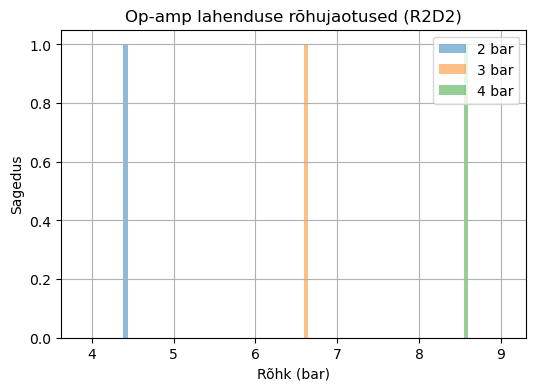

In [11]:
# Histogramm rõhkude jaotusest
fig, ax = plt.subplots()

for level, sub in opamp_df.groupby("level"):
    sub["pressure_bar"].hist(bins=20, alpha=0.5, label=level, ax=ax)

ax.set_xlabel("Rõhk (bar)")
ax.set_ylabel("Sagedus")
ax.set_title("Op-amp lahenduse rõhujaotused (R2D2)")
ax.legend()
plt.show()


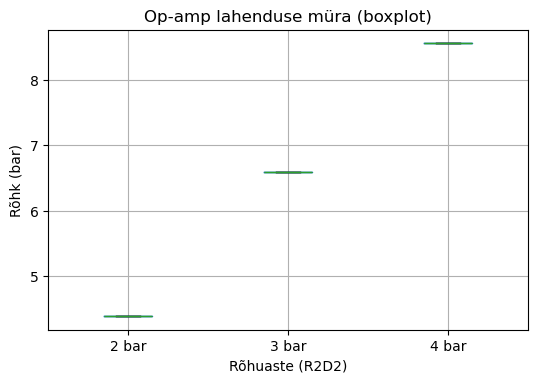

In [12]:
# Boxplot müra visuaalseks võrdluseks
opamp_df.boxplot(column="pressure_bar", by="level")
plt.xlabel("Rõhuaste (R2D2)")
plt.ylabel("Rõhk (bar)")
plt.title("Op-amp lahenduse müra (boxplot)")
plt.suptitle("")
plt.show()


In [13]:
op_stats.to_csv("opamp_stats.csv")
